In [1]:
import pandas as pd
import json
from environs import Env
from neo4j import GraphDatabase
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import operator
import requests
import math

In [2]:
env = Env()
env.read_env()

EPIGRAPHDB_SERVER = env.str("EPIGRAPHDB_SERVER")
EPIGRAPHDB_USER = "neo4j"
EPIGRAPHDB_PORT = env.str("EPIGRAPHDB_PORT")
EPIGRAPHDB_PASSWORD = env.str("EPIGRAPHDB_PASSWORD")
print(EPIGRAPHDB_PORT)

epigraphdb_driver = GraphDatabase.driver(
    "bolt://{server_name}:{port}".format(
        server_name=EPIGRAPHDB_SERVER, port=EPIGRAPHDB_PORT),
    auth=(EPIGRAPHDB_USER, EPIGRAPHDB_PASSWORD))

session = epigraphdb_driver.session()

37687


In [3]:
def query_to_df(query):
    print(query)
    data=session.run(query).data()
    df = pd.json_normalize(data)
    return(df)

In [ ]:

- Review Disease nodes
    - mapping to EFO
    - EFO to GWAS
    - review EFO of largest BC GWAS

## Looking for 'breast'-related diseases 

In [4]:
# just matching key word
query="""
MATCH (disease:Disease)
where toLower(disease.label) contains 'breast'
return distinct disease.label, disease.id
order by disease.id
"""
df = query_to_df(query)
df


MATCH (disease:Disease)
where toLower(disease.label) contains 'breast'
return distinct disease.label, disease.id
order by disease.id



,disease.label,disease.id
0,Abnormality of the breast,http://purl.obolibrary.org/obo/HP_0000769
1,Breast hypoplasia,http://purl.obolibrary.org/obo/HP_0003187
2,Aplasia/Hypoplasia of the breasts,http://purl.obolibrary.org/obo/HP_0010311
3,Abnormal breast morphology,http://purl.obolibrary.org/obo/HP_0031093
4,breast lobular carcinoma,http://purl.obolibrary.org/obo/MONDO_0000552
...,...,...
168,hormone-resistant breast carcinoma,http://purl.obolibrary.org/obo/MONDO_0056813
169,breast,http://purl.obolibrary.org/obo/UBERON_0000310
170,breast epithelium,http://purl.obolibrary.org/obo/UBERON_0008367
171,male breast,http://purl.obolibrary.org/obo/UBERON_0016410


### Get 'breast' diseases with EFO mapping

In [ ]:
query="""
MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo.value order by disease.label
"""
df = query_to_df(query)
df

## Disease -> EFO -> GWAS 

In [ ]:
query="""
MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo_to_gwas.score, gwas.id, gwas.trait, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by gwas.id
"""
df = query_to_df(query)
df

## Find what EFO the largest breast cancer GWAS are mapped to

In [5]:
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values,  
        count (efo.value) as N_EFO, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by toInteger(gwas.ncase) desc
"""
df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values,  
        count (efo.value) as N_EFO, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by toInteger(gwas.ncase) desc



,gwas.id,gwas.trait,EFO_IDs,EFO_values,N_EFO,N,n_case
0,prot-a-234,Breast cancer anti-estrogen resistance protein 3,[http://www.ebi.ac.uk/efo/EFO_0008040],[breast cancer anti-estrogen resistance protei...,1,3301.0,NaN
1,ebi-a-GCST004988,Breast cancer,"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",13,139274.0,76192.0
2,ieu-a-1129,Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",7,106776.0,61282.0
3,ieu-a-1130,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",11,89677.0,46785.0
4,ebi-a-GCST007236,Breast cancer,"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",13,89677.0,46785.0
5,ieu-a-1162,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",11,89677.0,46785.0
6,ieu-a-1132,ER+ Breast cancer (Oncoarray),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,83691.0,38197.0
7,ieu-a-1161,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000649, http://...","[estrogen-receptor positive breast cancer, est...",2,69970.0,27078.0
8,ieu-a-1133,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000649, http://...","[estrogen-receptor positive breast cancer, est...",2,69970.0,27078.0
9,ukb-b-16890,"Cancer code, self-reported: breast cancer","[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, cancer, estrogen-receptor p...",3,462933.0,10303.0


In [6]:
# now look only at 'ieu-a' GWAS
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id starts with 'ieu-a' and toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values, count (efo.value) as N_EFO,
       toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case , toInteger(gwas.year) as year
order by toInteger(gwas.ncase) desc
"""
df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id starts with 'ieu-a' and toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values, count (efo.value) as N_EFO,
       toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case , toInteger(gwas.year) as year
order by toInteger(gwas.ncase) desc



,gwas.id,gwas.trait,EFO_IDs,EFO_values,N_EFO,N,n_case,year
0,ieu-a-1129,Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, Her...",7,106776,61282,2017
1,ieu-a-1130,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000281, http://...","[basal-like carcinoma, breast ductal adenocarc...",11,89677,46785,2017
2,ieu-a-1162,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000281, http://...","[basal-like carcinoma, breast ductal adenocarc...",11,89677,46785,2015
3,ieu-a-1132,ER+ Breast cancer (Oncoarray),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,83691,38197,2017
4,ieu-a-1133,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, est...",2,69970,27078,2017
5,ieu-a-1161,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, est...",2,69970,27078,2015
6,ieu-a-1135,ER- Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",4,55149,9655,2017
7,ieu-a-1136,ER- Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0005607, http://...","[breast cancer stage, basal-like carcinoma, br...",6,50225,7333,2017
8,ieu-a-1160,ER- Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0005607, http://...","[breast cancer stage, basal-like carcinoma, br...",6,50225,7333,2015
9,ieu-a-1163,ER- Breast cancer (Survival),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,6881,920,2015


In [7]:
# showing the EFO assignments for the next largest GWAS
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id in ['ieu-a-1129', 'ieu-a-1132', 'ieu-a-1135']
SET gwas.name = gwas.`_name`
SET efo.name = efo.`_name`
return gwas.id,gwas.trait,  efo.id, efo.value, efo_to_gwas.score
order by gwas.id"""

df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id in ['ieu-a-1129', 'ieu-a-1132', 'ieu-a-1135']
SET gwas.name = gwas.`_name`
SET efo.name = efo.`_name`
return gwas.id,gwas.trait,  efo.id, efo.value, efo_to_gwas.score
order by gwas.id


,gwas.id,gwas.trait,efo.id,efo.value,efo_to_gwas.score
0,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000650,estrogen-receptor negative breast cancer,0.701004
1,ieu-a-1129,Breast cancer (Oncoarray),http://www.orpha.net/ORDO/Orphanet_227535,Hereditary breast cancer,0.702555
2,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000304,breast adenocarcinoma,0.710287
3,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005607,breast cancer stage,0.713407
4,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast cancer,0.715045
5,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer,0.737351
6,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma,0.801407
7,ieu-a-1132,ER+ Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer,0.718764
8,ieu-a-1135,ER- Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma,0.732981
9,ieu-a-1135,ER- Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast cancer,0.743182


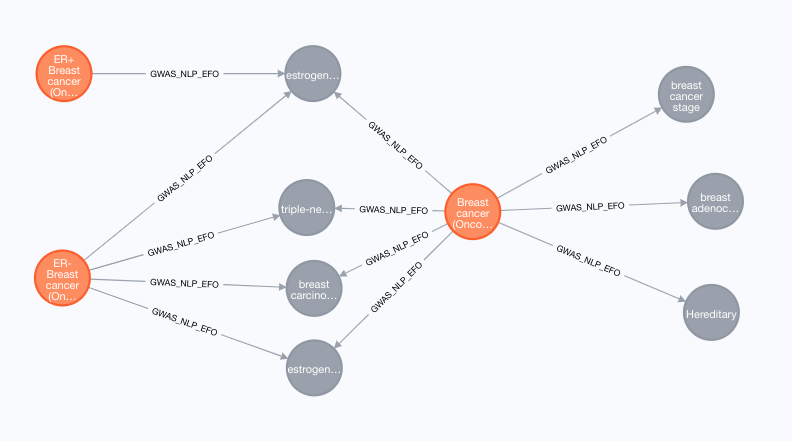

In [8]:
from IPython.display import Image
Image(filename = "gwas_efo.png", width = 800)

##  Disease label =  EFO ?  and GWAS name

In [10]:
# is it alaways same as EFO?
query="""
MATCH (gwas:Gwas)-[gwas_to_efo:GWAS_NLP_EFO]->(efo:Efo)<-[efo_disease:MONDO_MAP_EFO]-(disease:Disease) 
WHERE gwas_to_efo.score > 0.5 AND gwas.id = "ieu-a-1129" 
RETURN gwas.id, gwas.trait, gwas_to_efo.score,  efo.value, efo.id,  disease.label 
order by gwas_to_efo.score desc
"""

df = query_to_df(query)
df


MATCH (gwas:Gwas)-[gwas_to_efo:GWAS_NLP_EFO]->(efo:Efo)<-[efo_disease:MONDO_MAP_EFO]-(disease:Disease) 
WHERE gwas_to_efo.score > 0.5 AND gwas.id = "ieu-a-1129" 
RETURN gwas.id, gwas.trait, gwas_to_efo.score,  efo.value, efo.id,  disease.label 
order by gwas_to_efo.score desc



,gwas.id,gwas.trait,gwas_to_efo.score,efo.value,efo.id,disease.label
0,ieu-a-1129,Breast cancer (Oncoarray),0.801407,breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma
1,ieu-a-1129,Breast cancer (Oncoarray),0.737351,estrogen-receptor positive breast cancer,http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer
2,ieu-a-1129,Breast cancer (Oncoarray),0.715045,triple-negative breast cancer,http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast carcinoma
3,ieu-a-1129,Breast cancer (Oncoarray),0.710287,breast adenocarcinoma,http://www.ebi.ac.uk/efo/EFO_0000304,breast adenocarcinoma
4,ieu-a-1129,Breast cancer (Oncoarray),0.701004,estrogen-receptor negative breast cancer,http://www.ebi.ac.uk/efo/EFO_1000650,estrogen-receptor negative breast cancer
